<a href="https://colab.research.google.com/github/mehdi-or/Variational-AE/blob/master/Mnist_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import IPython as IP
IP.get_ipython().magic('reset -f')
import numpy as np
from keras.datasets import mnist
from keras import optimizers
from keras.layers import Input, Dense, concatenate, Dropout, Lambda
from keras.utils import to_categorical
#import pydotplus
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
import os
from scipy import stats
from keras import backend as K
from keras.regularizers import l2
#from keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.model_selection import GridSearchCV
#keras.utils.vis_utils.pydotplus = pydotplus
from keras.utils.vis_utils import plot_model
start = time.time()
#%reset -f

DNN architechture

In [30]:
encoding_dim = 2
drop = 0.02
activation_BT = 'linear'
num_epoch = 30
lr = 1e-4
discription = [str(encoding_dim), activation_BT, str(num_epoch), str(lr)]
def nna(encoding_dim):
      # this is our input placeholder for VT (creating a tensor)
      decoding_vox = Input(shape=(X_train.shape[1],), name="VT-input")

      encoded = Dense(512, activation='tanh', name="encoded_VT")(decoding_vox)
      encoded= Dropout(drop)(encoded)
      
      Bneck = Dense(encoding_dim, activation=activation_BT, name="Bneck")(encoded)
        
      decoded = Dense(512, activation='tanh', name="decoded-VT")(Bneck)
      decoded= Dropout(drop)(decoded)
      
      decoded = Dense(X_train.shape[1], activation='linear', name="decoded-output")(decoded)
      decoded= Dropout(drop)(decoded)
      

      encoder = Model(decoding_vox, Bneck)
      decoder = Model(decoding_vox, decoded) # model architecture
      plot_model(decoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
      
      
      bn_model = Model(inputs= decoder.input, outputs = decoder.get_layer('Bneck').output)
    
      # fitting the model and defining loss functiojn for each imput
      opt = optimizers.Adam(lr)
      decoder.compile(opt, loss='mean_squared_error', metrics=['mse', 'accuracy'])
      return decoder, encoder, Bneck, bn_model

importing data

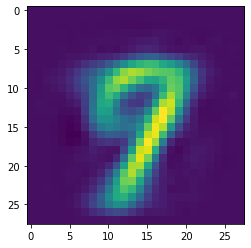

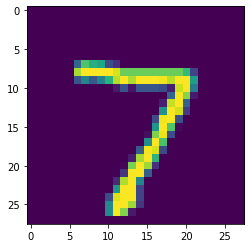

In [31]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.reshape(X_train/255,(X_train.shape[0],X_train.shape[1]**2))
X_test = np.reshape(X_test/255,(X_test.shape[0],X_test.shape[1]**2))

decoder, encoder, Bneck, bn_model = nna(encoding_dim)
decoder.fit(X_train, X_train, epochs= num_epoch, shuffle=True, validation_data=(X_test,X_test), verbose=0)
intermediate_layer_model = Model(inputs=decoder.input, outputs=decoder.get_layer('Bneck').output)
BottleNeck = intermediate_layer_model.predict(X_test)
bt_features = bn_model.predict(X_test)
decoded_VT = decoder.predict(X_test)
s=int(np.sqrt(decoded_VT.shape[1]))
decoded_VT0=np.reshape(decoded_VT,(decoded_VT.shape[0],s,s))
X_test0 = np.reshape(X_test,(X_test.shape[0],s,s))
plt.imshow(decoded_VT0[0,:,:])
plt.figure(2)
plt.imshow(X_test0[0,:,:])

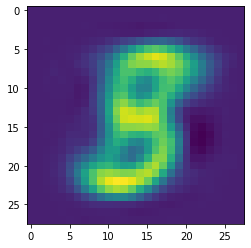

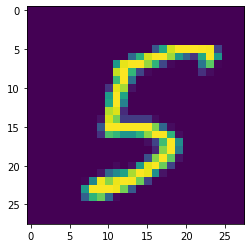

In [32]:
plt.imshow(decoded_VT0[23,:,:])
plt.figure(2)
plt.imshow(X_test0[23,:,:])

In [ ]:
print(BottleNeck[0:5,0:5])
print(bt_features[0:5,0:5])

classifier

In [33]:
classes = np.unique(y_test)
class_number = len(classes)
labels2categ = to_categorical(y_test, num_classes = class_number)
scl = MinMaxScaler(feature_range=(0,1))
BN_feat_scl = scl.fit_transform(BottleNeck)

BN_feat = Input(shape=(BottleNeck.shape[1],), name="BN")
out_class = Dense(classes.shape[0], activation='softmax', name ="output", kernel_regularizer=l2(0.007))(BN_feat)
classifier = Model(BN_feat, out_class, name='classifier')
#chossing the learning rate is very important
opt = optimizers.Adam(lr = 5e-5)
classifier.compile(opt, loss = 'categorical_crossentropy',  metrics =['accuracy'])

#labels2categ = to_categorical(labels2num[0, :], num_classes=len(class_number))
history=classifier.fit(BottleNeck, labels2categ, epochs=300, shuffle=True, validation_split = 0.2, verbose=0)

Plotting

Text(0.5, 1.0, 'BN features')

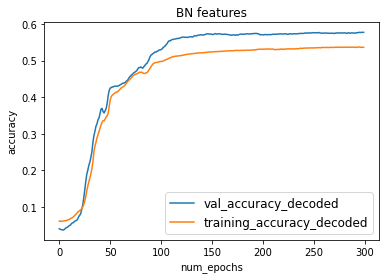

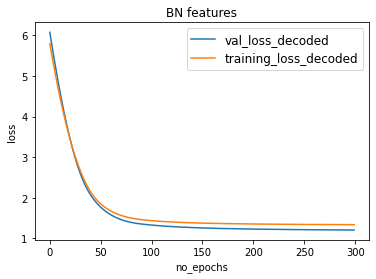

In [34]:
plt.figure(1)
plt.plot(np.asarray(history.history['val_accuracy']))
plt.plot(np.asarray(history.history['accuracy']))
plt.gca().legend(('val_accuracy_decoded','training_accuracy_decoded'), prop={'size': 12})
plt.xlabel('num_epochs')
plt.ylabel('accuracy')
plt.title('BN features')

plt.figure(2)
plt.plot(np.asarray(history.history['val_loss']))
plt.plot(np.asarray(history.history['loss']))
plt.gca().legend(('val_loss_decoded','training_loss_decoded'), prop={'size': 12})
plt.xlabel('no_epochs')
plt.ylabel('loss')
plt.title('BN features')

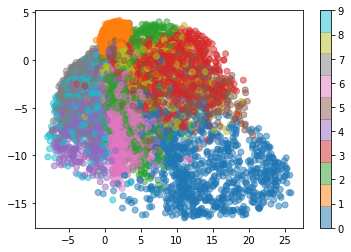

In [35]:
comp1 = BottleNeck[:,0]
comp2 = BottleNeck[:,1]
#comp3 = BottleNeck[:,2]
cmap = plt.cm.get_cmap('tab10')
plt.scatter(comp1, comp2, c= y_test, cmap=cmap, alpha=.5)
plt.colorbar(ticks=range(10))